In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('C://Users//conor//Downloads//Adops & Data Scientist Sample Data - Q2 Regression.csv', names=['A', 'B', 'C'])

In [3]:
data

,A,B,C
0,0.490,-0.180,11.50
1,-1.410,-1.230,11.80
2,0.943,4.510,-3.24
3,3.570,5.070,-23.90
4,-1.700,6.910,-22.10
...,...,...,...
295,6.920,-0.421,33.20
296,11.700,-1.290,108.00
297,9.920,3.690,-126.00
298,11.400,6.290,-315.00


In [4]:
from plotnine import *

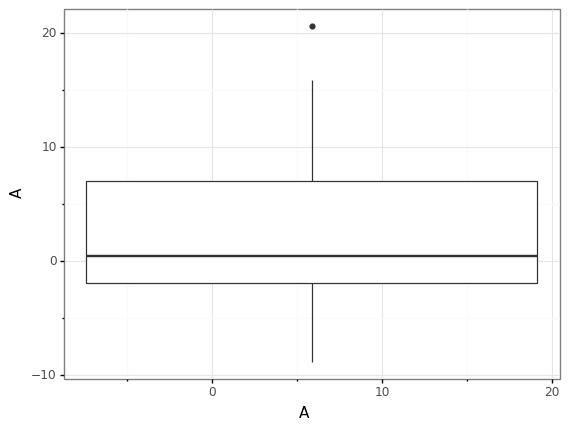

<ggplot: (-9223371912017823530)>

In [5]:
ggplot(data, aes(x='A', y='A')) + geom_boxplot() + theme_bw()

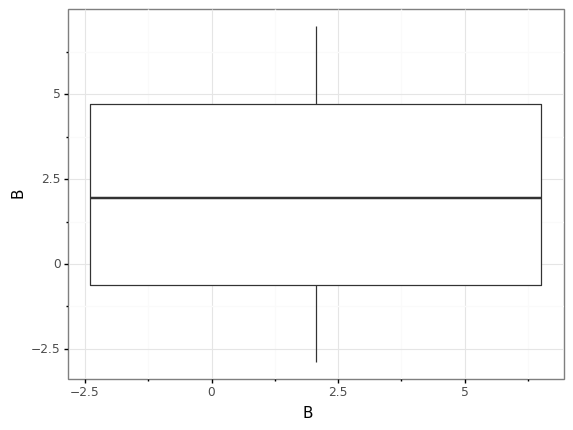

<ggplot: (124839129520)>

In [6]:
ggplot(data, aes(x='B', y='B')) + geom_boxplot() + theme_bw()

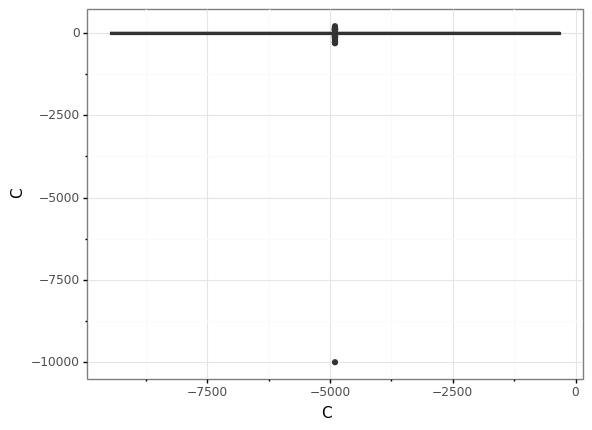

<ggplot: (124839172265)>

In [7]:
ggplot(data, aes(x='C', y='C')) + geom_boxplot() + theme_bw()

That is a huge outlier that is going to affect our results for Linear Regression so let's remove it.

In [8]:
data = data.loc[data['C'] > min(data['C'])]

In [9]:
def _turn_to_numpy(x):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
        return x.to_numpy()
    else:
        return np.array(x)


def _reshape_y(y):
    if len(y.shape) == 1:
        return _turn_to_numpy(y).reshape(y.shape[0], 1)

In [10]:
class LinearRegression:

    def __init__(self):
        """Creates a Linear Regression model, to be optimized using Ordinary Least Squares"""
        self.beta_0 = 0
        self.beta_1 = []

    def fit(self, X, y):
        """Fits a Linear Regression line using Ordinary Least Squares
        Parameters
        ----------
        X: pd.Series, pd.DataFrame, list or numpy array
            Our input vector
        y: list, pd.Series or numpy array
            Our output vector
        """

        X = _turn_to_numpy(X)
        y = _reshape_y(y)
        """
        From Elements of Statistical Learning, if we represent our train data as a N x (p + 1) matrix, with
        N := number of observations and p := number of features, with 1 in the first position we can set our RSS to be 
        RSS(β) = (y−X*β)T(y−X*β), with ∂RSS/∂β=−2*X_T(y−X*β) and ∂2RSS/∂β∂βT= 2*X_T*X.
        Then, by setting the first derivative equal to zero, X_T*(y−X*β) = 0, we can solve for β and obtain 
        β = (X_T*X)^−1*X_T*y.
        
        If you wish to check the dimensions, here it is:
        [[(p + 1) x N] * [N x (p+1)]]^-1 * [(p+1) x N] * [N x 1]
        [(p + 1) x (p + 1)] * [(p + 1) x N] * [N x 1]
        [(p + 1) x N] * [N x 1]
        [(p + 1) x 1]
        
        Note that this assumes that X_T * X is positive definite
        """
        if X.ndim > 1:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
        else:
            X = np.concatenate([np.ones([X.shape[0], 1]), X.reshape(X.shape[0], 1)], axis=1)
        X_T = np.transpose(X)
        inverse = np.linalg.inv(np.matmul(X_T, X))
        beta_hat = np.matmul(np.matmul(inverse, X_T), y)
        self.beta_0 = beta_hat[0]
        self.beta_1 = beta_hat[1:]

    def coefficients_(self):
        """Returns our coefficients (the slopes of each feature)"""
        return self.beta_1

    def intercept_(self):
        """Returns the y-intercept"""
        return self.beta_0

    def predict(self, X):
        """Returns our prediction for given X
        Parameters
        ----------
        X: list or numpy array
            The new input vector we are trying to generate predictions from
        Returns
        -------
        The predictions generated from our linear regression model"""
        X = _turn_to_numpy(X)
        return (self.beta_0 + np.dot(X, self.beta_1)).reshape(-1)

In [11]:
class RidgeRegression(LinearRegression):

    def __init__(self, penalty=0.5):
        """Creates a Linear Regression model with a L2 penalty term
        Parameters
        ----------
        penalty: float, default is 0.5
            Our L2 penalty
        """
        super(RidgeRegression).__init__()
        self.penalty = penalty

    def fit(self, X, y):
        """Fits a Linear Regression line using Ordinary Least Squares, with a Ridge Penalty using the L2 Norm
        Parameters
        ----------
        X: pd.Series, pd.DataFrame, list or numpy array
            Our input vector
        y: list, pd.Series or numpy array
            Our output vector
        Returns
        -------
        self: to be used for chaining for predict
        """

        X = _turn_to_numpy(X)
        y = _reshape_y(y)
        """
        From Elements of Statistical Learning, if we represent our train data as a N x (p + 1) matrix, with
        N := number of observations and p := number of features, with 1 in the first position we can set our RSS to be 
        RSS(λ) = (y−X*β)T(y−X*β) + λ*βT*β, with ∂RSS/∂β= −2*X_T(y−X*β) + 2*λ*β.
        Then, by setting the first derivative equal to zero,−2*X_T(y−X*β) + 2*λ*β = 0, we can solve for β and obtain 
        β = (X_T*X + λ*I)^−1*X_T*y, with I := identity matrix of dimension (p + 1) x (p + 1).
        If you wish to check the dimensions, here it is:
        [[(p + 1) x N] * [N x (p+1)] + [(p + 1) x (p + 1)]^-1 * [(p+1) x N] * [N x 1]
        [(p + 1) x (p + 1) + (p + 1) x (p + 1)] * [(p + 1) x N] * [N x 1]
        [(p + 1) x (p + 1)] * [(p + 1) x N] * [N x 1]
        [(p + 1) x N] * [N x 1]
        [(p + 1) x 1]
        Note that this assumes that X_T * X is positive definite
        """
        if X.ndim > 1:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
        else:
            X = np.concatenate([np.ones([X.shape[0], 1]), X.reshape(X.shape[0], 1)], axis=1)
        X_T = np.transpose(X)
        inverse = np.linalg.inv(np.add(np.matmul(X_T, X), np.identity(X.shape[1]) * self.penalty))
        beta_hat = np.matmul(np.matmul(inverse, X_T), y)
        self.beta_0 = beta_hat[0]
        self.beta_1 = beta_hat[1:]

In [12]:
from plotnine import *

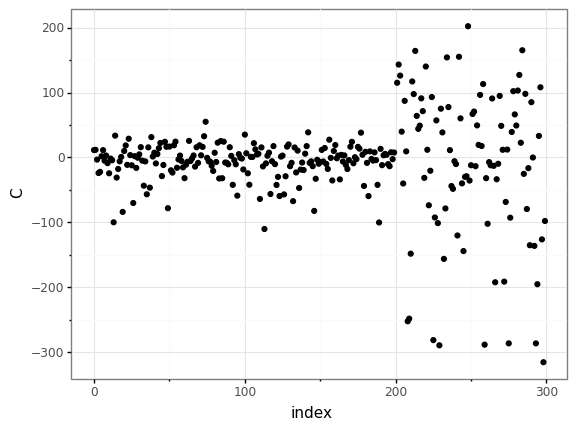

<ggplot: (124839174085)>

In [13]:
(ggplot(data=data.reset_index()) + geom_point(mapping=aes(x='index', y='C'), color='black') + theme_bw())

Here, we have an interesting situation where our data fits into roughly two modes. The first (from index 0-200) is tightly compact, whereas the later part (from index 200-300) is very spread out. 

So our model will do well on the data from index 0-200 (as they are tightly clustered together) but also terribly on data points 200-300 (as they are spread randomly).

Therefore, I expect a "well-performing" model to be one that most closely models points 0-200, as points 200-300 are too random in spred to be modeled accurately using something like linear regression. 

Now, something like gradient boosted trees may be able to identify this change in pattern, but it is non-trivial to implement from scratch compared to linear regression.

In [14]:
lr = LinearRegression()
rr = RidgeRegression()

In [15]:
X = data[['A', 'B']]
y = data['C']

In [16]:
lr.fit(X, y)
rr.fit(X, y)

In [17]:
y_hat = lr.predict(X)
y_hat2 = rr.predict(X)

In [18]:
def rmse(y, y_pred):
    rmse = np.sqrt(np.sum(np.power(y - y_pred, 2)) / len(y))
    return rmse

def r2_score(y, y_pred):
    mean_y = np.mean(y)
    sst = sum(np.power(y - mean_y, 2))
    sse = sum(np.power(y - y_pred, 2))
    r2 = 1 - (sse / sst)
    return r2

In [19]:
print(rmse(y, y_hat))
print(rmse(y, y_hat2))

55.42728751329778
55.42732259135182


In [20]:
print(r2_score(y, y_hat))
print(r2_score(y, y_hat2))

0.3940222102143234
0.3940214432084189


In [21]:
data['A_plus_B'] = data['A'] + data['B']
data['A_minus_B'] = data['A'] - data['B']
data['A_times_B'] = data['A'] * data['B']
data['A_divided_B'] = data['A'] / data['B']
data['max_AB'] = data[['A', 'B']].max(axis=1)
data['A_squared'] = np.power(data['A'], 2)
data['B_squared'] = np.power(data['B'], 2)
data['A_diff_mean'] = data['A'] - data['A'].mean()
data['B_diff_mean'] = data['B'] - data['B'].mean()
data['A_diff_median'] = data['A'] - data['A'].median()
data['B_diff_median'] = data['B'] - data['B'].median()

c:\users\conor\documents\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\conor\documents\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\conor\documents\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [22]:
X2 = data.drop(['C'], axis=1)

In [23]:
lr.fit(X2, y)
rr.fit(X2, y)

In [24]:
y_hat = lr.predict(X2)
y_hat2 = rr.predict(X2)

In [25]:
print(rmse(y, y_hat))
print(rmse(y, y_hat2))

79.81280797758332
32.13223302252944


In [26]:
print(r2_score(y, y_hat))
print(r2_score(y, y_hat2))

-0.2564772691580077
0.7963467848147548


In [27]:
rr.coefficients_()

array([[  5.35678807],
       [  3.08217386],
       [  8.43896194],
       [  2.27461421],
       [ -3.72436721],
       [ -0.40641966],
       [-15.62822177],
       [ -0.01875481],
       [  0.79275058],
       [ -5.41024131],
       [ -6.44581299],
       [  3.25599987],
       [ -6.03534092]])

Based on these results, we can drop A_divided_B, A_squared and B_squared, and not see a noticeable drop in performance.

In [28]:
from plotnine import *

In [29]:
X3 = X2.drop(['A_divided_B', 'A_squared', 'B_squared'], axis=1)
rr.fit(X3, y)

In [30]:
y_hat2 = rr.predict(X3)

In [31]:
print(rmse(y, y_hat2))

32.891101397603215


In [32]:
print(r2_score(y, y_hat2))

0.7866138201578677


In [33]:
actual_v_pred = pd.DataFrame([y, y_hat, y_hat2]).T.reset_index()

In [34]:
actual_v_pred.columns = ['index', 'actual', 'linear', 'ridge']

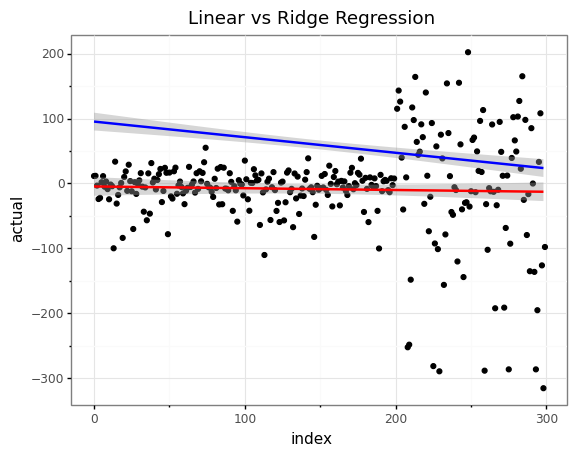

<ggplot: (-9223371912015480274)>

In [35]:
(ggplot(data=actual_v_pred) + geom_point(mapping=aes(x='index', y='actual'), color='black') + 
 geom_smooth(mapping=aes(x='index', y='linear'), color='blue', method='lm') + 
 geom_smooth(mapping=aes(x='index', y='ridge'), color='red', method='lm') + theme_bw() +
 ggtitle("Linear vs Ridge Regression"))